In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cols = ['Redshift', 'Distance', 'Error']
obs = pd.read_csv('SN.data', names=cols, header=0)

<ErrorbarContainer object of 3 artists>

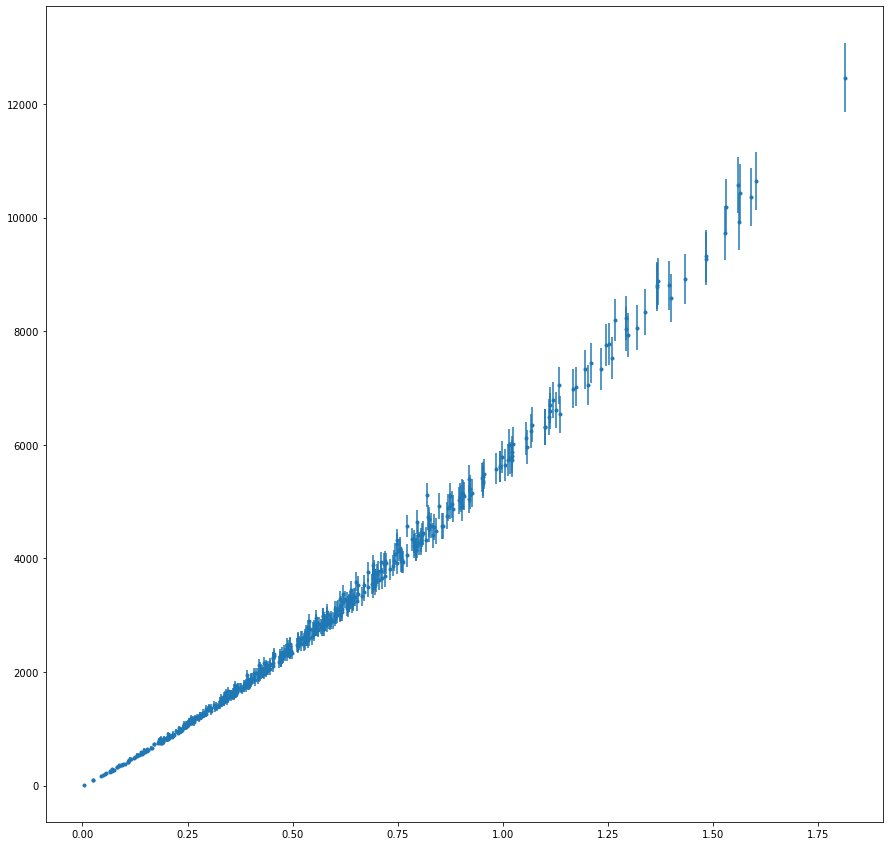

In [3]:
fig, ax = plt.subplots(figsize=(15,15))
ax.errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.')

(array([42., 72., 74., 69., 72., 39., 36., 22., 20., 12., 10.,  7.,  6.,
         4.,  7.,  2.,  4.,  1.,  0.,  1.]),
 array([   14.69059466,   637.23347795,  1259.77636124,  1882.31924453,
         2504.86212782,  3127.40501111,  3749.94789441,  4372.4907777 ,
         4995.03366099,  5617.57654428,  6240.11942757,  6862.66231086,
         7485.20519416,  8107.74807745,  8730.29096074,  9352.83384403,
         9975.37672732, 10597.91961061, 11220.4624939 , 11843.0053772 ,
        12465.54826049]),
 <BarContainer object of 20 artists>)

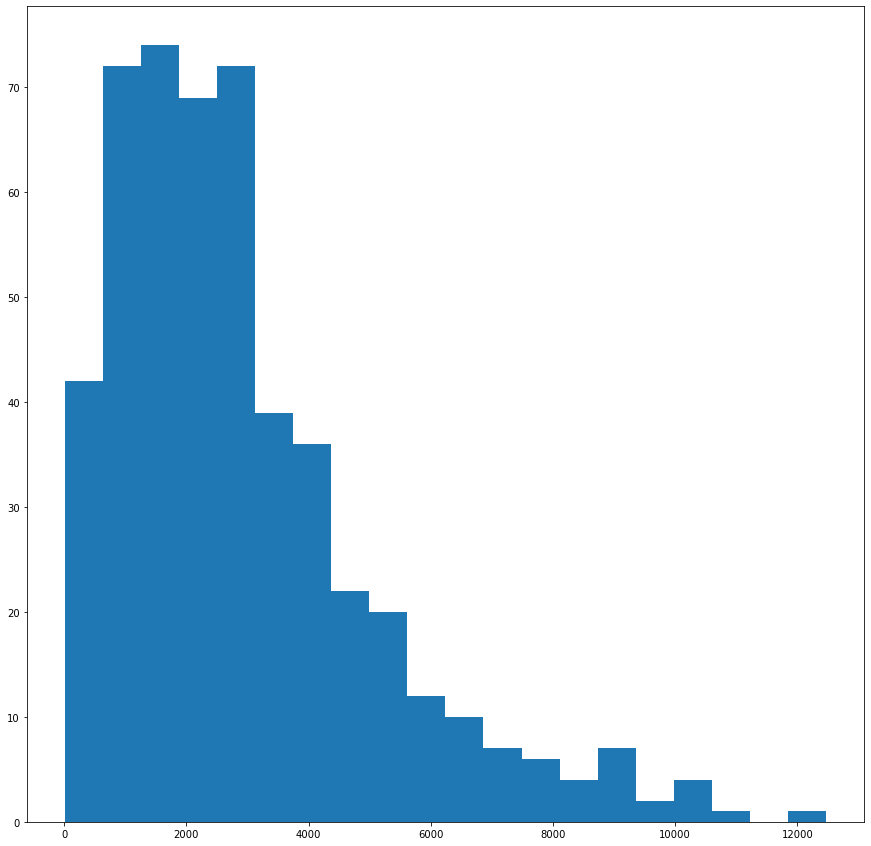

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
ax.hist(obs['Distance'], bins = 20)

In [5]:
from astropy.cosmology import LambdaCDM

In [6]:
# want luminosity distance as a fn of redshift

In [7]:
from scipy.optimize import curve_fit

def func(z, H0, Om0, Ode0):
    print(H0)
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    return cosmo.luminosity_distance(z).value

In [8]:
popt, pcov = curve_fit(func, obs['Redshift'], obs['Distance'])
perr = np.sqrt(np.diag(pcov))

fit = LambdaCDM(H0=popt[0], Om0=popt[1], Ode0=popt[2])




#chi2 np.sum((data.loc[data['Redshift'] == z]['Distance'][0] - fit.luminosity_distance(z).value))
    

1.0
1.0
1.0
1.0000000149011612
1.0
1.0
1.9871218233399113
1.9871218529503338
1.9871218233399113
1.9871218233399113
3.923467953269875
3.9234680117341036
3.923467953269875
3.923467953269875
7.649559995446989
7.649560109434315
7.649559995446989
7.649559995446989
14.552855014385774
14.552855231240212
14.552855014385774
14.552855014385774
26.429688775560972
26.429689169394024
26.429688775560972
26.429688775560972
44.15130758091124
44.15130823881699
44.15130758091124
44.15130758091124
64.3181252503606
64.31812620877535
64.3181252503606
64.3181252503606
77.96042518724718
77.96042634894805
77.96042518724718
77.96042518724718
81.41726482295925
81.41726603617104
81.41726482295925
81.41726482295925
81.56722542341457
81.56722663886094
81.56722542341457
81.56722542341457
81.56740708265957


In [9]:
popt

array([81.56740708,  0.2150506 ,  0.6119503 ])

In [10]:
import pymc3 as pm
import theano
import theano.tensor as t

# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

data = obs['Distance']
data_err = obs['Error']
redshifts = obs['Redshift']

@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar],otypes=[t.dvector])
def complexmodel(H0, Om0, Ode0):
    z = redshifts
    cosmo = LambdaCDM(H0=float(H0), Om0=float(Om0), Ode0=float(Ode0))
    def function(z):
        return cosmo.luminosity_distance(z).value
    
    function = function(z)
    return function

with pm.Model() as model:
    # Parameters should have uniform priors (?)
    H0 = pm.Uniform('H0', lower=40, upper=100)
    Om0 = pm.Uniform('Om0', lower=0, upper=1)
    Ode0 = pm.Uniform('Ode0',lower=0,upper=1)
    
    complexmodel=complexmodel(H0, Om0, Ode0)
    
    # TODO - actually figure out what the prior should be
    # Likelyhood of observed data
    dist = pm.Normal('LumDist', complexmodel, observed=data, sd=data_err)
    
    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Ode0]
>Metropolis: [Om0]
>Metropolis: [H0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 149 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [11]:
traces_to_pandas(traces, 1000)

,H0,Om0,Ode0
0,80.687753,0.186895,0.500256
1,80.687753,0.186895,0.500256
2,80.657296,0.186895,0.500256
3,80.657296,0.186895,0.500256
4,80.426470,0.184774,0.500256
...,...,...,...
99995,81.878904,0.185723,0.590456
99996,81.878904,0.185723,0.590456
99997,81.878904,0.205696,0.589549
99998,81.878904,0.205696,0.589549


In [12]:
MCMC_fit =  LambdaCDM(H0=traces['H0'][-1], Om0=traces['Om0'][-1], Ode0=traces['Ode0'][-1])
obs['Fit'] = obs.apply(lambda row: 0, axis=1)
for index, z in enumerate(obs['Redshift']):
    obs['Fit'][index] = MCMC_fit.luminosity_distance(z).value

obs['Fit_Diff'] = obs.apply(lambda row: np.abs(row.Distance - row.Fit), axis=1)

redshifts_smooth = np.linspace(0,1.9,500)


/home/michael/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
obs


,Redshift,Distance,Error,Fit,Fit_Diff
0,0.336886,1480.919735,73.014139,1515,34.080265
1,0.186857,750.610735,37.321367,774,23.389265
2,0.442316,2088.225990,100.775470,2091,2.774010
3,0.388877,1789.298150,86.443520,1793,3.701850
4,0.181246,768.578074,36.080277,748,20.578074
...,...,...,...,...,...
495,0.140422,554.107761,27.264601,565,10.892239
496,0.919220,5040.818899,249.077286,5173,132.181101
497,0.429994,1984.276772,97.424628,2021,36.723228
498,0.239588,1014.942769,49.325590,1023,8.057231


In [14]:
from scipy.stats import chisquare

chisquare(obs.Distance, obs.Fit)

Power_divergenceResult(statistic=1182.8894908003783, pvalue=1.913980914063844e-57)

''

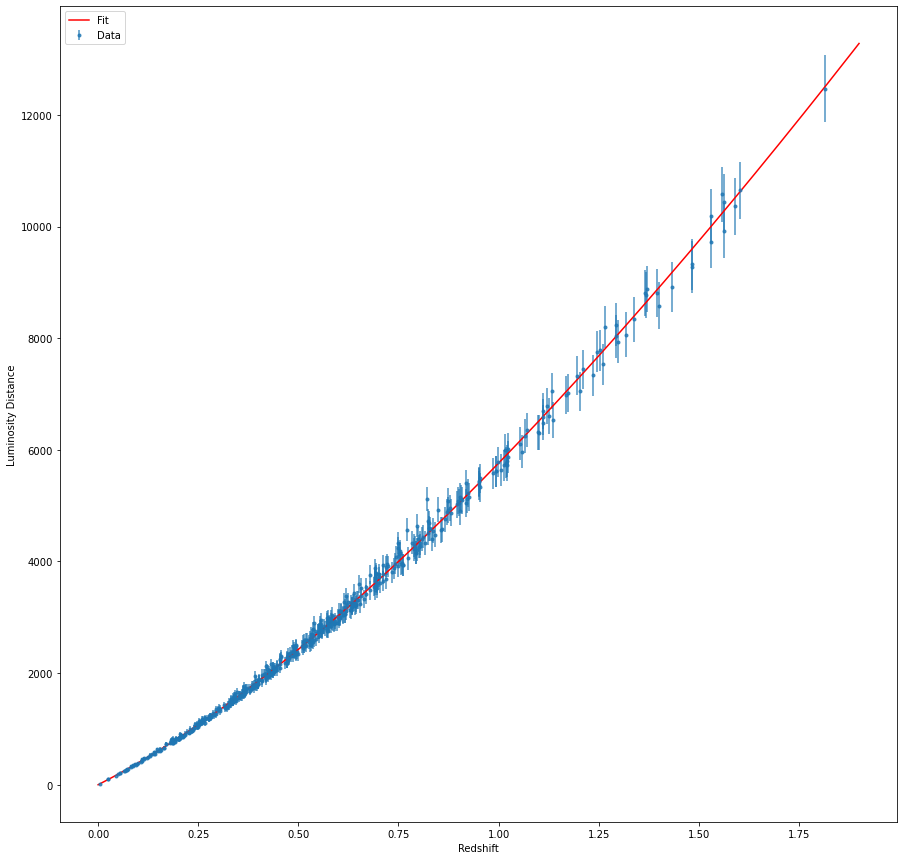

In [21]:
obs.sort_values(['Redshift'])

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(redshifts_smooth, MCMC_fit.luminosity_distance(redshifts_smooth).value, ls='-', c = 'r', label='Fit')
ax.errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.', alpha=.8, label='Data')
ax.set_ylabel('Luminosity Distance')
ax.set_xlabel('Redshift')
ax.legend()

;

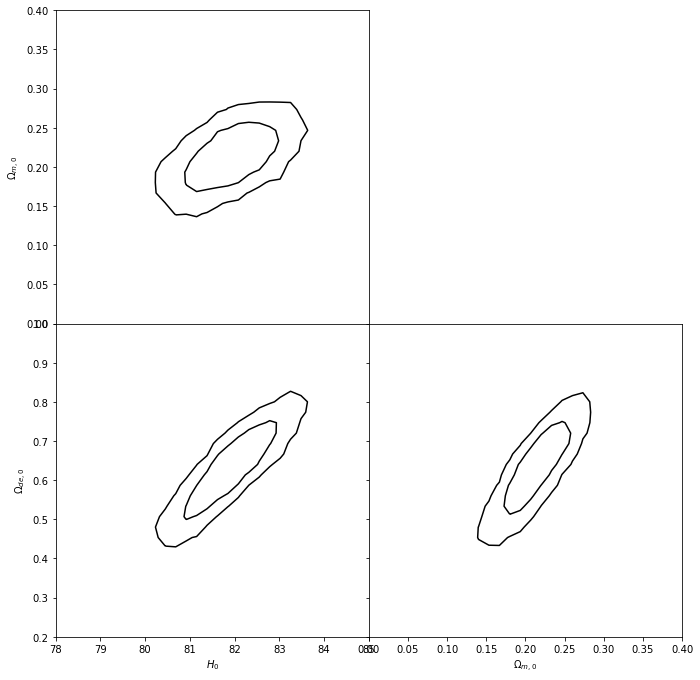

In [16]:
from astroML.plotting import hist, plot_mcmc

df = traces_to_pandas(traces, 1000)

variables = ['H0', 'Om0', 'Ode0']
labels = ['$H_0$', '$\Omega_{m,0}$', '$\Omega_{de,0}$']
limits = [(78, 85), (0, 0.4), (0.2, 1)]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits, fig=fig, bins=30, colors='k')

#marginalize

<BarContainer object of 500 artists>

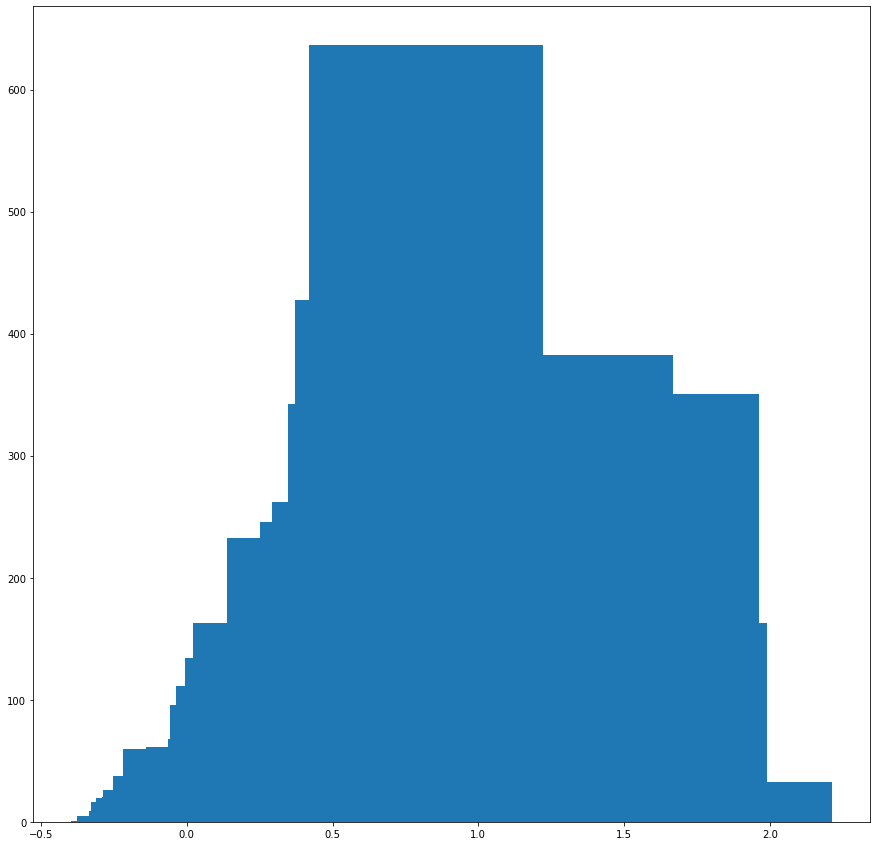

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(obs['Redshift'], obs['Fit_Diff'])

<BarContainer object of 500 artists>

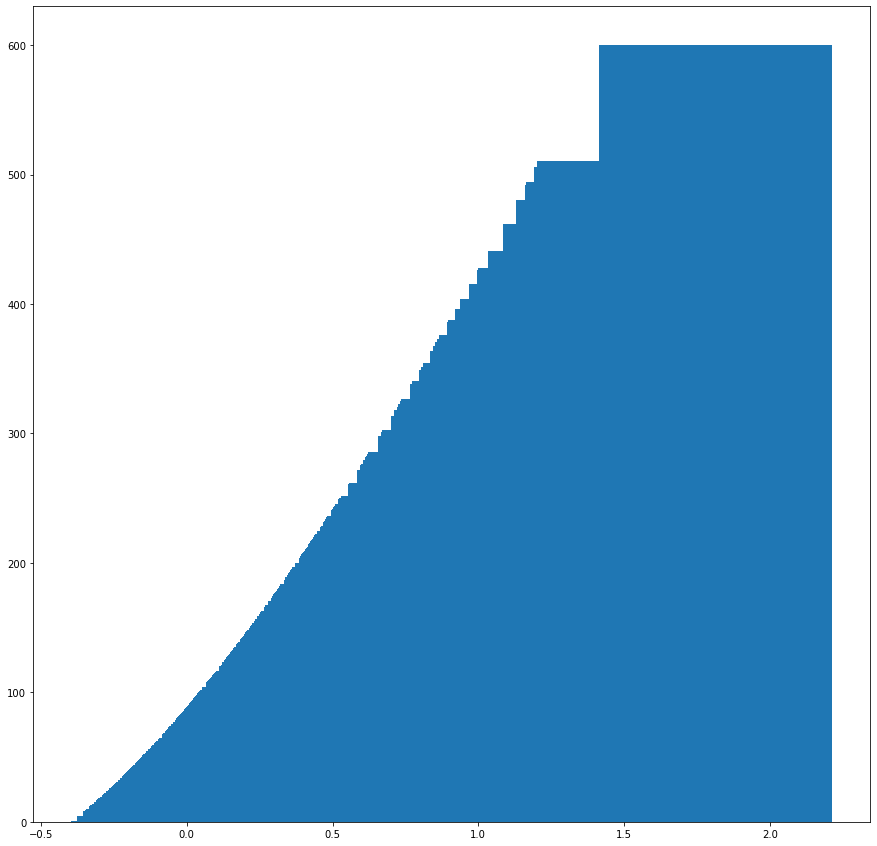

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(obs['Redshift'], obs['Error'])

In [19]:
pm.sample?

Signature:
pm.sample(
    draws=1000,
    step=None,
    init='auto',
    n_init=200000,
    start=None,
    trace=None,
    chain_idx=0,
    chains=None,
    cores=None,
    tune=1000,
    progressbar=True,
    model=None,
    random_seed=None,
    discard_tuned_samples=True,
    compute_convergence_checks=True,
    callback=None,
    *,
    return_inferencedata=None,
    idata_kwargs: dict = None,
    mp_ctx=None,
    pickle_backend: str = 'pickle',
    **kwargs,
)
Docstring:
Draw samples from the posterior using the given step methods.

Multiple step methods are supported via compound step methods.

Parameters
----------
draws : int
    The number of samples to draw. Defaults to 1000. The number of tuned samples are discarded
    by default. See ``discard_tuned_samples``.
init : str
    Initialization method to use for auto-assigned NUTS samplers.

    * auto: Choose a default initialization method automatically.
      Currently, this is ``jitter+adapt_diag``, but this can change in